# The `Qui`jote matter `P`ower spectrum emulator (QUIP)

In this notebook we introduce `QUIP` and assess the prediction accuracy.

We start by loading all the required modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matryoshka.plot as MatPlot
import matryoshka.halo_model_funcs as MatHM
import matryoshka.emulator as MatEmu
import time
from scipy.interpolate import interp1d

We next load the matter power spectrum measurements from the [Quijote simulations](https://arxiv.org/abs/1909.05273) at $z=0.5$. These are publically available, see the [Quijote docs](https://quijote-simulations.readthedocs.io/en/latest/) for instructions on access.

In [2]:
QUIJOTE_samples = np.loadtxt('/Users/jamie/Quijote/latin_hypercube_params.txt')
Pk_QUIJOTE = []
for i in range(2000):
    k, Pk = np.loadtxt('/Users/jamie/Quijote/{a}/Pk_m_z=0.5.txt'.format(a=i),
                       unpack=True)
    Pk_QUIJOTE.append(Pk)
Pk_QUIJOTE = np.stack(Pk_QUIJOTE)
ks_QUIJOTE = k # k-bins are the same for all Quijote samples.

We can plot these power spectra to observe the range from Quijote.

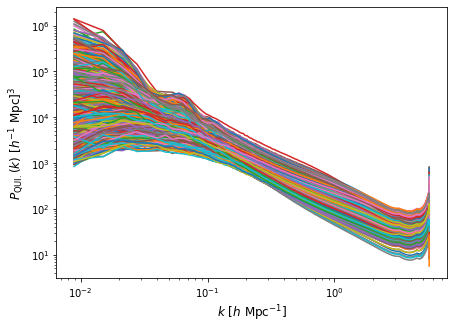

In [3]:
plt.figure(1, figsize=(7,5))

plt.loglog(ks_QUIJOTE, Pk_QUIJOTE.T)

plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$", fontsize='large')
plt.ylabel(r"$P_\mathrm{QUI.}(k) \ [h^{-1} \ \mathrm{Mpc}]^3$", fontsize='large')

plt.show()

Next we load the transfer function and matter nonlinear boost emulator from `matryoshka`. Along with the indicies that distinguish the Quijote simulations that were used for training and those that will we use to assess the accuracy from `matryosha`.

In [4]:
# Updates to the dataset function will be made to make this step easier.
test_id = np.load("/Users/jamie/Desktop/GitHubProjects/Matryoshka/matryoshka-data/QUIP/split_indicies/boost/test.npy")
train_id = np.load("/Users/jamie/Desktop/GitHubProjects/Matryoshka/matryoshka-data/QUIP/split_indicies/boost/train.npy")

We need to specify which version of the transfer function emulator to load, as there are now multiple included in `matryoshka`. We also need to specify which redshift we want to make predictions at. This is done via the `redshift_id` argument rather than specifying the redshift directly. This is done because there are distinct emulators for each redshift from the Quijote simulations.

In [5]:
Transfer = MatEmu.Transfer(version='QUIP')
MatterBoost = MatEmu.MatterBoost(redshift_id=1)

2021-11-11 15:47:20.554560: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We then make predictions for the train and test cosmologies. It should be noted that these are the train test splits for the nonlnear boost emulator. The transfer function emulator wasn't trained on any of the Quijote cosmologies.

In [6]:
Transfer_preds_train = Transfer.emu_predict(QUIJOTE_samples[train_id], mean_or_full='mean')
Transfer_preds_test = Transfer.emu_predict(QUIJOTE_samples[test_id], mean_or_full='mean')
Boost_preds_train = MatterBoost.emu_predict(QUIJOTE_samples[train_id], mean_or_full='mean')
Boost_preds_test = MatterBoost.emu_predict(QUIJOTE_samples[test_id], mean_or_full='mean')

To compare these predictions to the Quijote simulations we need to calculate the linear power spectrum from the transfer function predictions, and then the nonlinear power spectrum by combining the boost predictions with these linear power spectra.

We calculate the linear power spectra via
$$P(k,z=0) = A k^{n_s} T(k)^2\ ,$$
where the normalisation $A$ is calculated from $\sigma_8$.

In [7]:
linPk_train = MatHM.power0_v2(Transfer.kbins, Transfer_preds_train, sigma8=QUIJOTE_samples[train_id][:,4],
                              ns=QUIJOTE_samples[train_id][:,3])
linPk_test = MatHM.power0_v2(Transfer.kbins, Transfer_preds_test, sigma8=QUIJOTE_samples[test_id][:,4],
                              ns=QUIJOTE_samples[test_id][:,3])

To claculate the linear power at $z=0.5$ we must calculate the linear growth factor $D(z)$. Given we are only considering $\Lambda$CMD cosmologies we can do this easily analytically.
$$D(a) = \frac{5\Omega_m}{2}\frac{H(a)}{H_0}\int_0^a\left[\frac{H(a)}{H_0}a\right]^{-3}da\ .$$

In [8]:
growths_train = np.zeros((QUIJOTE_samples[train_id].shape[0],))
for i in range(QUIJOTE_samples[train_id].shape[0]):
    growths_train[i] = MatHM.DgN(QUIJOTE_samples[train_id][i,0],0.5)/MatHM.DgN(QUIJOTE_samples[train_id][i,0],0.)
    
growths_test = np.zeros((QUIJOTE_samples[test_id].shape[0],))
for i in range(QUIJOTE_samples[test_id].shape[0]):
    growths_test[i] = MatHM.DgN(QUIJOTE_samples[test_id][i,0],0.5)/MatHM.DgN(QUIJOTE_samples[test_id][i,0],0.)

In [9]:
# We interpolate here becase we only want the linear prediction where we have the boost prediction.
linPk_train = interp1d(Transfer.kbins, linPk_train, kind='cubic')(MatterBoost.kbins)*(growths_train**2).reshape(-1,1)
linPk_test = interp1d(Transfer.kbins, linPk_test, kind='cubic')(MatterBoost.kbins)*(growths_test**2).reshape(-1,1)

Finally we compute the nonlinear matter power spectrum by combining the linear power with the boost.
$$P_{nl}(k) = P_L(k)B(k)\ .$$

In [10]:
Pk_preds_train = linPk_train*Boost_preds_train
Pk_preds_test = linPk_test*Boost_preds_test

Before comparing the predictions from `QUIP` to the Quijote simulations we should note that `QUIP` does not predict the nonlinear boost over the full $k$-range shown in the plot above. `QUIP` has only been trained to predict the boost up to $k\sim 1 \ h \ \mathrm{Mpc}^{-1}$. We limit the $k$-range as on these very small scales effects coming from the resolution of the simulation and the grid used to measure the power spectrum start to become significant.

The power spectra were measured with a grid size of $N_\mathrm{grid}=1024$ (see [here](https://github.com/franciscovillaescusa/Quijote-simulations/blob/master/Pk/Pk_matter.py)). This results in a Nyquist frequency of 
$$k_\mathrm{Nyq.}=\frac{\pi N_\mathrm{grid}}{L_\mathrm{box}}=\frac{\pi 1024}{1000 \ h^{-1} \ \mathrm{Mpc}}\approx 3.1 \ h \ \mathrm{Mpc}^{-1}\ ,$$
so a cut of $k<1\ h \ \mathrm{Mpc}^{-1}$ is very conservative and is $\ll\frac{k_\mathrm{Nyq.}}{2}$.

After cutting the Quijote power spectra we can finally make a comparison with the `QUIP` predictions.

In [11]:
ks_good = ks_QUIJOTE < 1.0

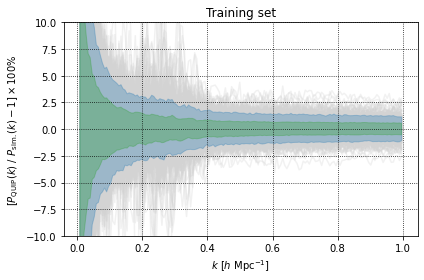

In [12]:
MatPlot.per_err(Pk_QUIJOTE[:,ks_good][train_id], Pk_preds_train, MatterBoost.kbins, ylim=(-10,10),
                title="Training set", xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
                ylabel=r"$[P_\mathrm{QUIP}(k) \ / \ P_\mathrm{sim.}(k)-1] \times 100\%$")

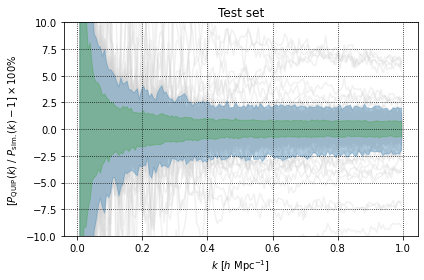

In [13]:
MatPlot.per_err(Pk_QUIJOTE[:,ks_good][test_id], Pk_preds_test, MatterBoost.kbins, ylim=(-10,10),
                title="Test set", xlabel=r"$k \ [h \ \mathrm{Mpc}^{-1}]$", 
                ylabel=r"$[P_\mathrm{QUIP}(k) \ / \ P_\mathrm{sim.}(k)-1] \times 100\%$")

Observing the percentage errors in the plots above we can see that the the $1\sigma$ (green shaded) region is very simular when making predictions on the test and training set. However we can see that the $2\sigma$ (blue shaded) region is larger when making preditions on the test set. This is suggesting some degree of overfitting, but `QUIP` still produces predictions that have an error $<2.5\%$ on scales $0.4\ h \ \mathrm{Mpc}^{-1}<k<1\ h \ \mathrm{Mpc}^{-1}$.

We can also see from the plots above that there appears to be an explosion in the prediction error on scales $<0.3\ h \ \mathrm{Mpc}^{-1}$. It should however be noted that the measurements of the power spectra do contain a significant amount of noise on these scales as such infering prediction accuracy on these scales from these plots will lead to an over estimate of the prediction error.

A quick way to try and get a better estimate of the prediction accuracy on these scales is to compare the `QUIP` predictions to another emulator, such as the `BACCO` emulator. Of the 2000 Quijote cosmologies only 24 fall into the region covered by the `BACCO` emulator. We start by comparing the `BACCO` predictions to the Quijote matter power directly.

In [14]:
Pk_BACCO = np.loadtxt("/Users/jamie/Desktop/QUIP/Pk_Bacco_z0p5.csv", delimiter=",", skiprows=1)[:,1:].T
ks_BACCO = np.loadtxt("/Users/jamie/Desktop/QUIP/Pk_Bacco_z0p5.csv", delimiter=",", skiprows=1)[:,0]

common_cosmo_ids = np.load("/Users/jamie/Desktop/QUIP/common_cosmoID_bacco.npy")

Pk_QUIJOTE_int = interp1d(ks_QUIJOTE, Pk_QUIJOTE[common_cosmo_ids], kind="cubic")(ks_BACCO)

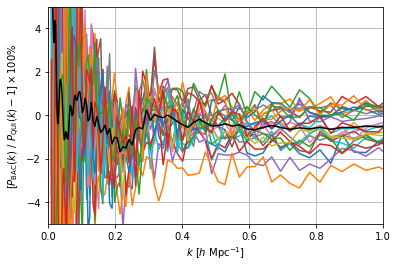

In [15]:
plt.plot(ks_BACCO, ((Pk_BACCO/Pk_QUIJOTE_int-1)*100).T)
plt.plot(ks_BACCO, ((Pk_BACCO/Pk_QUIJOTE_int-1)*100).mean(axis=0), color='k')
plt.grid()
plt.ylim(-5,5)
plt.xlim(0,1)

plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$[P_\mathrm{BAC}(k) \ / \ P_\mathrm{QUI}(k)-1] \times 100\%$")
plt.show()

We can see from the plot above that there is generally good agreement between the Quijote power spectra and the `BACCO` predictions. There does apear to be a feature in the percentage errors plotted above at $k\sim 0.2\ h \ \mathrm{Mpc}^{-1}$. It also appears that on average the Quijote power spectra have a greater amplitude on small scales.

Now that we have confirmed that there is generally good agreement between `BACCO` and Quijote, we move on to making the comarison between `BACCO` and `QUIP`.

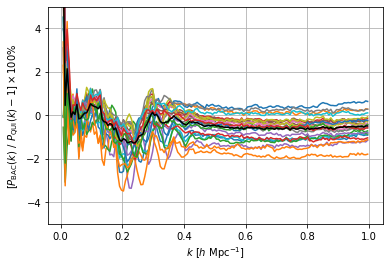

In [29]:
Transfer_preds_BACCO = Transfer.emu_predict(QUIJOTE_samples[common_cosmo_ids], mean_or_full='mean')
MatterBoost_preds_BACCO = MatterBoost.emu_predict(QUIJOTE_samples[common_cosmo_ids], mean_or_full='mean')

linPk_BACCO = MatHM.power0_v2(Transfer.kbins, Transfer_preds_BACCO, sigma8=QUIJOTE_samples[common_cosmo_ids][:,4],
                              ns=QUIJOTE_samples[common_cosmo_ids][:,3])

growths_BACCO = np.zeros((QUIJOTE_samples[common_cosmo_ids].shape[0],))
for i in range(QUIJOTE_samples[common_cosmo_ids].shape[0]):
    growths_BACCO[i] = MatHM.DgN(QUIJOTE_samples[common_cosmo_ids][i,0],0.5)/MatHM.DgN(QUIJOTE_samples[common_cosmo_ids][i,0],0.)

linPk_BACCO = interp1d(Transfer.kbins, linPk_BACCO, kind='cubic')(MatterBoost.kbins)*(growths_BACCO**2).reshape(-1,1)

Pk_preds = linPk_BACCO*MatterBoost_preds_BACCO

Pk_BACCO_int = interp1d(ks_BACCO, Pk_BACCO, kind='cubic', bounds_error=False,
                        fill_value='extrapolate')(MatterBoost.kbins)

plt.plot(MatterBoost.kbins, ((Pk_BACCO_int/Pk_preds-1)*100).T)
plt.plot(MatterBoost.kbins, ((Pk_BACCO_int/Pk_preds-1)*100).mean(axis=0), color='k')
plt.grid()
plt.ylim(-5,5)

plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$[P_\mathrm{BAC}(k) \ / \ P_\mathrm{QUI}(k)-1] \times 100\%$")
plt.show()

We can see from the plot above that `QUIP` and `BACCO` agree well for the 24 common cosmologies. We can also see that the explosion of prediction error observed when comparing `QUIP` to Quijote is not as stron when comparing to `BACCO`. We also see that the feature at $k\sim 0.2\ h \ \mathrm{Mpc}^{-1}$ is still present.